In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)
print(f"Using device: {device}")

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # flatten 32x32x3 to 3072
    transforms.Lambda(lambda x: x.to(torch.float32))  # ensure cons dtype
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

batch_size = 128
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True  # workers alive between epochs
)

Files already downloaded and verified


In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=512, latent_dim=32):  # increased dims
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_var = nn.Linear(hidden_dim // 2, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self): # to add kaiming init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [4]:
model = VAE().to(device)
test_batch, _ = next(iter(trainloader))
test_batch = test_batch.to(device)
recon_batch, mu, log_var = model(test_batch)

print(f"input shape: {test_batch.shape}")
print(f"reconstructed shape: {recon_batch.shape}")
print(f"mu shape: {mu.shape}")
print(f"log_var shape: {log_var.shape}")

input shape: torch.Size([128, 3072])
reconstructed shape: torch.Size([128, 3072])
mu shape: torch.Size([128, 32])
log_var shape: torch.Size([128, 32])


In [5]:
def loss_function(recon_x, x, mu, log_var, kld_weight=0.5):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='mean') * x.size(1)
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + kld_weight * KLD

In [6]:
def train(model, trainloader, epochs=10):

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for batch_idx, (data, _) in enumerate(tqdm(trainloader)):
            data = data.to(device)
            optimizer.zero_grad(set_to_none=True)

            recon_batch, mu, log_var = model(data)

            # dynamic KLD
            kld_weight = min((epoch + 1) / (epochs // 4), 1.0)
            loss = loss_function(recon_batch, data, mu, log_var, kld_weight)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'batch [{batch_idx}/{len(trainloader)}] loss: {loss.item():.4f}')

        avg_loss = total_loss / len(trainloader.dataset)
        print(f"epoch [{epoch+1}/{epochs}] avg loss: {avg_loss:.4f}")
        scheduler.step()

    return model

In [7]:
def plot_reconstruction(model, data):
    model.eval()
    with torch.no_grad():

        recon_batch, _, _ = model(data.to(device))

        # plot original and reconstruction
        plt.figure(figsize=(12, 6))

        for i in range(8):
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
            if i == 0:
                plt.title("original")

        for i in range(8):
            plt.subplot(2, 8, i + 9)
            plt.imshow(recon_batch[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
            if i == 0:
                plt.title("reconstruction")

        plt.tight_layout()

  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 3135.5005
batch [100/391] loss: 2015.1072
batch [200/391] loss: 1938.2588
batch [300/391] loss: 1936.0258
epoch [1/10] avg loss: 15.5122


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1879.2429
batch [100/391] loss: 1866.5656
batch [200/391] loss: 1887.5133
batch [300/391] loss: 1886.2745
epoch [2/10] avg loss: 14.6589


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1843.1210
batch [100/391] loss: 1851.0217
batch [200/391] loss: 1849.3744
batch [300/391] loss: 1840.2076
epoch [3/10] avg loss: 14.4266


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1854.0361
batch [100/391] loss: 1854.6852
batch [200/391] loss: 1818.5876
batch [300/391] loss: 1824.9302
epoch [4/10] avg loss: 14.2985


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1815.9486
batch [100/391] loss: 1797.8530
batch [200/391] loss: 1804.4730
batch [300/391] loss: 1830.1790
epoch [5/10] avg loss: 14.2178


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1803.7098
batch [100/391] loss: 1779.6636
batch [200/391] loss: 1823.6870
batch [300/391] loss: 1803.7567
epoch [6/10] avg loss: 14.1600


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1787.7072
batch [100/391] loss: 1804.1257
batch [200/391] loss: 1796.7367
batch [300/391] loss: 1827.4258
epoch [7/10] avg loss: 14.1179


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1791.7383
batch [100/391] loss: 1798.1477
batch [200/391] loss: 1823.3557
batch [300/391] loss: 1783.9150
epoch [8/10] avg loss: 14.0904


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1800.6456
batch [100/391] loss: 1762.2219
batch [200/391] loss: 1798.2843
batch [300/391] loss: 1798.0870
epoch [9/10] avg loss: 14.0719


  0%|          | 0/391 [00:00<?, ?it/s]

batch [0/391] loss: 1795.3906
batch [100/391] loss: 1817.2134
batch [200/391] loss: 1794.1947
batch [300/391] loss: 1824.6084
epoch [10/10] avg loss: 14.0633


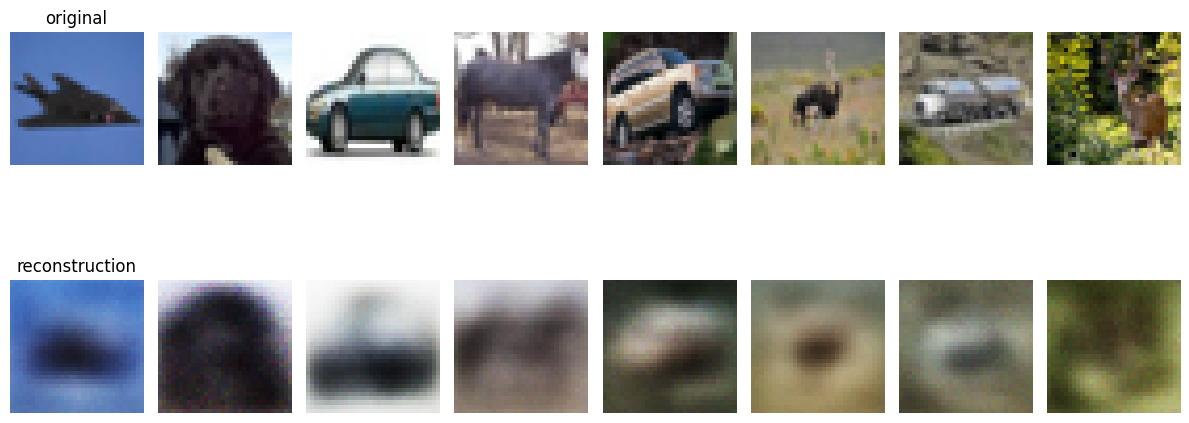

In [8]:
model = VAE().to(device)
train(model, trainloader, epochs=10)

test_batch, _ = next(iter(trainloader))
plot_reconstruction(model, test_batch)

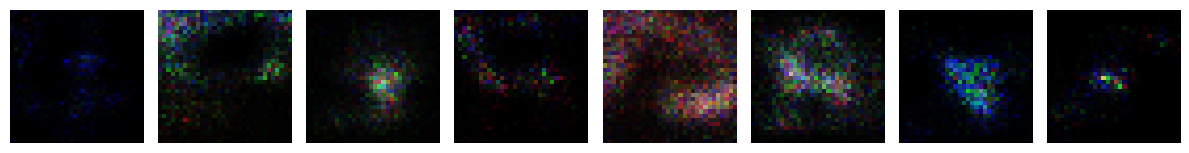

In [11]:
def generate_images(model, num_images=8):
    model.eval()
    with torch.no_grad():

        latent_dim = model.fc_mu.out_features
        z = torch.randn(num_images, latent_dim).to(device)
        sample = model.decoder(z)

        plt.figure(figsize=(12, 3))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(sample[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
        plt.tight_layout()

generate_images(model)